# 딥러닝 이상 탐지 알고리즘 벤치마킹, 개발 및 배포를 위한 라이브러리

> 주의:
> 이 노트북은 원래 Kaggle의 @innat에 의해 생성되었습니다. [Kaggle에서 보기](https://www.kaggle.com/code/ipythonx/mvtec-ad-anomaly-detection-with-anomalib-library/notebook).

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib는 공개 및 비공개 데이터셋에서 벤치마킹을 위해 최신 이상 탐지 알고리즘을 수집하는 목적을 가진 딥러닝 라이브러리입니다. Anomalib는 최근 문헌에 설명된 이상 탐지 알고리즘의 준비된 구현뿐만 아니라, 사용자 정의 모델의 개발과 구현을 용이하게 하는 일련의 도구를 제공합니다. 라이브러리는 이미지 기반 이상 탐지에 중점을 두고 있으며, 알고리즘의 목표는 데이터셋 내의 이상 이미지나 이미지 내의 이상 픽셀 영역을 식별하는 것입니다.

라이브러리는 **벤치마킹**을 위해 [`MVTec AD`](https://www.mvtec.com/company/research/datasets/mvtec-ad) (CC BY-NC-SA 4.0)와 [`BeanTech`](https://paperswithcode.com/dataset/btad) (CC-BY-SA), 그리고 사용자 정의 데이터셋 **훈련/추론**을 위한 `folder`를 지원합니다. 이 노트북에서는 `MVTec AD` 병 데이터셋에서 PADIM 모델을 훈련시키고 모델 성능을 평가하는 `anomalib` 훈련을 탐구할 것입니다. 이 노트북의 섹션들은 `tools/train.py`의 단계들을 더 자세히 탐구합니다. CLI를 통해 결과를 재현하고 싶은 분들은 `python tools/train.py --model patchcore`을 사용할 수 있습니다.


## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomal_util.config import get_configurable_parameters
from anomal_util.data import get_datamodule
from anomal_util.data.utils import read_image
from anomal_util.deploy import OpenVINOInferencer
from anomal_util.models import get_model
from anomal_util.pre_processing.transforms import Denormalize
from anomal_util.utils.callbacks import LoadModelCallback, get_callbacks
import os
from pathlib import Path
from typing import Any

current_directory = Path.cwd()
os.chdir(current_directory)

## Model

현재 anomalib 라이브러리에서 사용할 수 있는 이상 탐지 모델은 13개입니다. 구체적으로는 다음과 같습니다:

- [CFA](https://arxiv.org/abs/2206.04325)
- [CS-Flow](https://arxiv.org/abs/2110.02855v1)
- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/main/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [DRAEM](https://arxiv.org/abs/2108.07610)
- [FastFlow](https://arxiv.org/abs/2111.07677)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [Reverse Distillation](https://arxiv.org/abs/2201.10703)
- [R-KDE](https://ieeexplore.ieee.org/document/8999287)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

이 튜토리얼에서는 patchcore 사용할 것입니다. 이제 각 모델의 설정 파일 경로를 해당 폴더에서 가져오겠습니다.

구성
이 시연에서는 위 목록에서 [Patchcore](https://arxiv.org/pdf/2106.08265.pdf) 모델을 선택할 것입니다. 이제 이 모델의 구성 파일을 빠르게 살펴보겠습니다.

In [2]:
MODEL = "patchcore"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = current_directory / f"anomal_util/models/{MODEL}/config.yaml"
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: mvtec
  format: mvtec
  path: E:\Mytask\main\Dataset\MVTec
  task: segmentation
  category: leather
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: 224 # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.5 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16



구성 파일을 경로에서 읽어서 사전 형태로 반환하는 get_configurable_parameter 함수를 사용할 수 있습니다. Padim 구현에 포함된 기본 구성 파일을 사용하며, 이 파일은 데이터셋의 경로로 ./datasets/MVTec를 사용합니다. 구성을 로드한 후에는 이 경로를 덮어쓸 필요가 있습니다.

In [3]:
# pass the config file to model, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)

e:\Mytask\main\fhailib\anomal_util\config\config.py:243: UserWarning: The seed value is now fixed to 0. Up to v0.3.7, the seed was not fixed when the seed value was set to 0. If you want to use the random seed, please select `None` for the seed value (`null` in the YAML file) or remove the `seed` key from the YAML file.
  warn(



## 데이터셋: MVTec AD

**MVTec AD**는 산업 검사에 초점을 맞춘 이상 탐지 방법의 벤치마킹을 위한 데이터셋입니다. 이 데이터셋은 15개의 다른 객체 및 텍스처 카테고리로 나누어진 5000개 이상의 고해상도 이미지를 포함하고 있습니다. 각 카테고리에는 결함이 없는 훈련 이미지 세트와 다양한 종류의 결함이 있는 이미지 및 결함이 없는 이미지의 테스트 세트가 포함되어 있습니다. 데이터셋이 루트 데이터셋 디렉토리에 위치하지 않은 경우, anomalib는 자동으로 데이터셋을 설치합니다.

이제 anomalib에 구현된 특정 데이터모듈을 사용하여 MVTec AD 데이터셋을 가져올 수 있습니다.

In [4]:
datamodule = get_datamodule(config)
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask'])


입력 이미지와 마스크의 형태를 확인해 보겠습니다.

In [5]:
print(data["image"].shape, data["mask"].shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 224, 224])



이제 검증 세트에서 정상 및 비정상 샘플을 시각화할 수 있습니다.

e:\Mytask\main\fhailib\anomal_util\pre_processing\transforms\custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


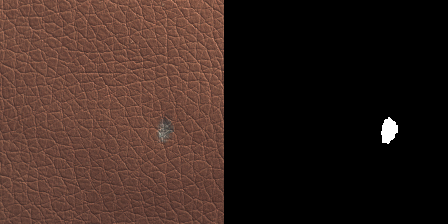

In [6]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    img = ToPILImage()(Denormalize()(sample["image"][index].clone()))
    msk = ToPILImage()(sample["mask"][index]).convert("RGB")

    return Image.fromarray(np.hstack((np.array(img), np.array(msk))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)


# 모델과 콜백 준비
이제 구성 파일을 원하는 대로 업데이트했습니다. 이제 이를 사용하여 모델 훈련을 시작할 수 있습니다. 여기서는 'datamodule', 'model, 그리고 'callbacks'을 사용하여 모델을 훈련할 것입니다. 콜백은 비필수 로직을 포함하는 독립적인 객체입니다. 이 방식을 통해 ModelLoading, Timer, Metrics, Normalization, Visualization 등 가능한 많은 콜백을 주입할 수 있습니다.

훈련과 더불어, OpenVINO를 사용한 추론을 수행하고 싶습니다. 따라서 anomalib가 훈련된 모델을 openvino 형식으로 내보낼 수 있도록 내보내기 구성을 openvino로 설정할 것입니다.

In [7]:
# Set the export-mode to OpenVINO to create the OpenVINO IR model.
config.optimization.export_mode = "openvino"

# Get the model and callbacks
model = get_model(config)
callbacks = get_callbacks(config)

e:\conda\envs\test\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


In [8]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: DATA\patchcore\lightning_logs
e:\conda\envs\test\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\conda\envs\test\lib\site-packages\pytorch_lightning\core\optimizer.py:183: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(

  | Name                  | Type                     | Params
---------------------

Training: 0it [00:00, ?it/s]

e:\conda\envs\test\lib\site-packages\pytorch_lightning\loops\optimization\optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]



































































































































































































































































































































































































































































































































































































































































































































































































Selecting Coreset Indices.: 100%|██████████| 19208/19208 [01:20<00:00, 237.27it/s]
`Trainer.fit` stopped: `max_epochs=1` reached.
e:\Mytask\main\fhailib\anomal_util\models\patchcore\torch_model.py:209: TracerWarning: Converting a 

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



e:\Mytask\main\fhailib\anomal_util\deploy\export.py:219: UserWarning: Transform CenterCrop is not supported currently
  warn(f"Transform {transform} is not supported currently")
e:\Mytask\main\fhailib\anomal_util\deploy\export.py:219: UserWarning: Transform ToTensorV2 is not supported currently
  warn(f"Transform {transform} is not supported currently")


## 평가

In [9]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │            1.0            │
│        pixel_AUROC        │    0.9886937737464905     │
│       pixel_F1Score       │    0.4167136251926422     │
└───────────────────────────┴───────────────────────────┘

## OpenVINO Inference
Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.

### OpenVINO 추론
모델을 훈련하고 테스트한 이후, OpenVINO 추론 객체를 사용하여 단일 추론 결과를 확인할 수 있습니다. 이는 훈련된 모델을 추론에 어떻게 사용할 수 있는지를 보여줍니다.

In [10]:
image_path = "./Dataset/MVTec/leather/test/color/000.png"
image = read_image(path=image_path)
plt.imshow(image)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


### OpenVINO 모델 로드하기

기본적으로 출력 파일들은 results 디렉토리에 저장됩니다. OpenVINO 모델이 어디에 저장되어 있는지 확인해 보겠습니다.

In [ ]:
output_path = Path(config["project"]["path"])
print(output_path)

In [ ]:
openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
metadata = output_path / "weights" / "openvino" / "metadata.json"
print(openvino_model_path.exists(), metadata.exists())

In [ ]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

### 추론 수행
OpenVINO 추론기를 사용하여 이미지를 예측하는 것은 'predict' 메소드를 호출하는 것만큼 간단합니다.

In [ ]:
print(image.shape)

In [ ]:
predictions = inferencer.predict(image=image)

여기서 predictions는 작업 유형과 관련된 모든 관련 정보를 포함합니다. 예를 들어, 분할 모델의 예측에는 이미지, 이상 맵, 예측 점수, 라벨 또는 마스크가 포함될 수 있습니다.

### 결과 표시

In [ ]:
print(predictions.pred_score, predictions.pred_label)

In [ ]:
# Visualize the original image
plt.imshow(predictions.image)

In [ ]:
# Visualize the raw anomaly maps predicted by the model.
plt.imshow(predictions.anomaly_map)

In [ ]:
# Visualize the heatmaps, on which raw anomaly map is overlayed on the original image.
plt.imshow(predictions.heat_map)

In [ ]:
# Visualize the segmentation mask.
plt.imshow(predictions.pred_mask)

In [ ]:
# Visualize the segmentation mask with the original image.
plt.imshow(predictions.segmentations)